In [291]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pylab
import turtle
import cv2
import random
import time
import sys
import PIL
from collections import deque
from itertools import combinations,groupby
import time
import string
from pygsp import graphs, filters
import re

In [293]:
#check libraries versions
#print("networkX version: "+str(pkg_resources.get_distribution("networkx").version))
#print("opencv   version: "+str(pkg_resources.get_distribution("opencv-python").version))
#print("pygsp   version: "+str(pkg_resources.get_distribution("pygsp").version))

In [295]:
#https://github.com/Oslandia/qgis-swmm/blob/master/example/example1.inp
path="C:\\Users\\shse\\Documents\\ANACONDA\\UTwin\\faf_feb16_apr20.inp"

In [297]:
lkm=[]
file = open(path, "r")
lines=file.readlines()
for l in lines:
    lkm.append(l)
file.close()


In [299]:
def extract_info(file_text,delimeter="\s"):#deimeters for inp - \s,\t

    substring1="COORDINATES"
    substring2="CONDUITS"
    
    Node_Names=[]
    Nodes_coord_X=[]
    Nodes_coord_Y=[]

    Cond_Names=[]
    Nodes_in=[]
    Nodes_out=[]

    #service variables
    #nodes
    substr1_offset=2
    string1_substring="["
    string1_list=[]
    coord_flag=False
    
    #conduits
    substr2_offset=2
    string2_substring="["
    string2_list=[]
    
    
    #this are the Nodes information
    for k in file_text:
        
        if(coord_flag==False):
            try:
                k.index(substring1)
            except ValueError:
                pass
            else:
                coord_flag=True
        else:
            try:
                k.index(string1_substring)            
            except ValueError:
                string1_list.append(k)
            else:
                break
    
    offset=2
    #nodes names and coordinates
    for k in range (offset,len(string1_list)):
        str_tmp=string1_list[k]
        str_list=re.split(delimeter,str(str_tmp)) #str(k).split(delimeter)
        str_list = list(filter(None, str_list))        
        if(len(str_list)==3):
            Node_Names.append(str_list[0].strip())
            Nodes_coord_X.append(float(str_list[1].strip()))
            Nodes_coord_Y.append(float(str_list[2].strip()))

    #----------------------------------------
    #this is conduit information
    #----------------------------------------
    
    coord_flag=False
    
    for k in file_text:
        
        if(coord_flag==False):
            try:
                k.index(substring2)
            except ValueError:
                pass
            else:
                coord_flag=True
        else:
            try:
                k.index(string1_substring)            
            except ValueError:
                string2_list.append(k)
            else:
                break

    #check if the list includes the needed information
    #print(string2_list)
    Length=[]
    Roughness=[]
    InOffset=[]
    OutOffset  =[]
    InitFlow   =[]
    MaxFlow=[]
    
    offset=3
    #conduits names and coordinates
    for g in range(offset,len(string2_list)):        
        k=string2_list[g]        
        str_list=re.split(delimeter,str(k))#str(k).partition(delimeter) #split(delimeter)
        #remove empty elements frmom list
        str_list = list(filter(None, str_list))
        
        if(len(str_list)==9):
            Cond_Names.append((str_list[0]).strip())
            Nodes_in.append  ((str_list[1]).strip())
            Nodes_out.append ((str_list[2]).strip())
            Length.append    ((str_list[3]).strip())
            Roughness.append ((str_list[4]).strip())
            InOffset.append  ((str_list[5]).strip())
            OutOffset.append ((str_list[6]).strip())
            InitFlow.append  ((str_list[7]).strip())
            MaxFlow.append   ((str_list[8]).strip())
    
    return Node_Names, Nodes_coord_X, Nodes_coord_Y, Cond_Names, Nodes_in, Nodes_out

In [301]:
Node_Names,Nodes_coord_X,Nodes_coord_Y,Cond_Names,Nodes_in,Nodes_out =extract_info(lkm)
points=[]
for g in range(0,len(Nodes_coord_X)):
    points.append((Nodes_coord_X[g],Nodes_coord_Y[g]))

In [305]:
#CREATE GRAPH BASED ON THE DATA FROM INP FILE

In [307]:
Graph = nx.DiGraph(directed=True,strict=True)#Graph()
#add nodes
for l in range(0,len(Node_Names)):
    Graph.add_node(Node_Names[l], pos=(float(points[l][0]), float(points[l][1])),
                   value=float(0.0), #actual water level                    
                   depth=0.92, #this defines the offset - e.g. the distance from the floor of the well to the out pipe (imposing delays of water flow)
                   saturation_falg=False,
                   sturation_level=0, #the water level cant go above this value, imitating flooding
                   water_loss_flag=True,#precipittaion, evaporation and other water loss things
                   water_loss_rate=0.87
                  )

graph_nodes_n=len(Node_Names)

min_x_coord= np.min(np.asarray(points)[:,0])
max_x_coord= np.max(np.asarray(points)[:,0])

min_y_coord= np.min(np.asarray(points)[:,1])
max_y_coord= np.max(np.asarray(points)[:,1])

print("Map dimensions:")
print("X min: " +str(min_x_coord))
print("X max: " +str(max_x_coord))
print("Y min: " +str(min_y_coord))
print("Y max: " +str(max_y_coord))
print("")
print("Nodes number: "+str(graph_nodes_n))


#add edges
cnt_edge=0
for i in range(0,len(Cond_Names)):
    indx_in=0
    indx_out=0
    for h in range(0,len(Node_Names)):
        if(Nodes_in[i]==Node_Names[h]):
            indx_in=h
        if(Nodes_out[i]==Node_Names[h]):
            indx_out=h
    #Graph.add_edge(indx_in, indx_out, egdes = cnt_edge)
    Graph.add_edge(Node_Names[indx_in], Node_Names[indx_out], egdes = cnt_edge, weight=0.82)
    cnt_edge=cnt_edge+1
    

Map dimensions:
X min: 697526.013
X max: 699814.894
Y min: 248338.455
Y max: 249842.635

Nodes number: 440


In [309]:
pos2={}
for i in range(0,len(points)):
    pos2[Node_Names[i]] =  np.asarray((float(points[i][0]),float(points[i][1])))   
    #class a: pass
    #a.node_name =  ""
    #a.pos       =  np.asarray((0,0))    
    #setattr(a,"node_name", str(Node_Names[i]))    
    #setattr(a,"pos", np.asarray((float(points[i][0]),float(points[i][1]))))
    #pos2.update(a)

#pos = {n_name:np.array(x, y)  for (n_name, (x,y)) in nx.get_node_attributes(Graph, 'pos').items()}
#pos1=nx.spring_layout(Graph)
#print(pos1)
#print("==================================")
#print(pos2)
#print("==================================")

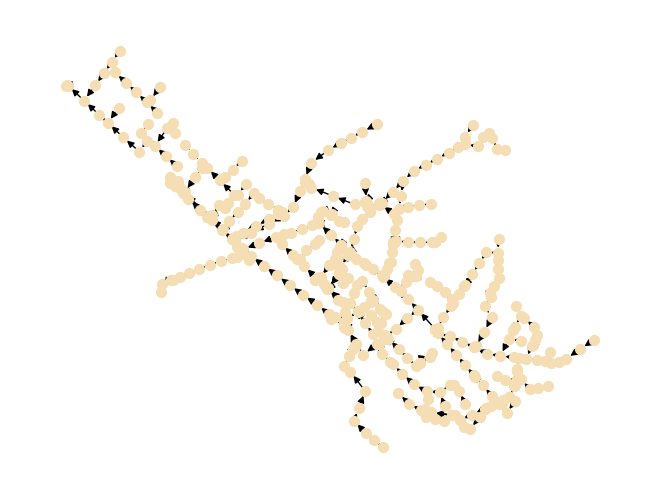

In [313]:
nx.draw(Graph, pos=pos2, node_color='wheat', node_size=50,with_labels=False)
pylab.show()

In [314]:
Adj_M = nx.adjacency_matrix(Graph)
print(Adj_M)#.todense())

  (0, 1)	0.82
  (1, 2)	0.82
  (2, 3)	0.82
  (4, 5)	0.82
  (5, 6)	0.82
  (6, 7)	0.82
  (7, 2)	0.82
  (8, 422)	0.82
  (9, 4)	0.82
  (10, 11)	0.82
  (11, 12)	0.82
  (12, 427)	0.82
  (13, 14)	0.82
  (14, 15)	0.82
  (15, 16)	0.82
  (16, 18)	0.82
  (17, 18)	0.82
  (18, 19)	0.82
  (19, 42)	0.82
  (20, 21)	0.82
  (21, 22)	0.82
  (22, 23)	0.82
  (23, 24)	0.82
  (24, 25)	0.82
  (25, 26)	0.82
  :	:
  (404, 67)	0.82
  (405, 426)	0.82
  (406, 405)	0.82
  (407, 428)	0.82
  (408, 0)	0.82
  (409, 435)	0.82
  (410, 431)	0.82
  (411, 433)	0.82
  (412, 58)	0.82
  (413, 22)	0.82
  (414, 375)	0.82
  (415, 418)	0.82
  (416, 202)	0.82
  (417, 107)	0.82
  (417, 233)	0.82
  (418, 204)	0.82
  (419, 409)	0.82
  (420, 407)	0.82
  (421, 73)	0.82
  (422, 31)	0.82
  (423, 10)	0.82
  (424, 8)	0.82
  (425, 245)	0.82
  (426, 144)	0.82
  (426, 183)	0.82


In [317]:
#lorenz attractor
#https://matplotlib.org/stable/gallery/mplot3d/lorenz_attractor.html
class Lorenz:

    def __init__(self):
        
        self.dt=0.01
        self.num_steps=1000
        self.map=np.empty
        self.nRow = 50
        self.nCol = 50
        self.xyzs=np.empty
        self.xyz_hist=[]
        
    def lorenz(self,xyz, *, s=10, r=28, b=2.667):    
        
        """
        Parameters
        ----------
        xyz : array-like, shape (3,)
           Point of interest in three-dimensional space.
        s, r, b : float
           Parameters defining the Lorenz attractor.
        
        Returns
        -------
        xyz_dot : array, shape (3,)
           Values of the Lorenz attractor's partial derivatives at *xyz*.
        """
        
        x, y, z = xyz
        x_dot = s*(y - x)
        y_dot = r*x - y - x*z
        z_dot = x*y - b*z
        
        return np.array([x_dot, y_dot, z_dot])

    def Reset(self):
        self.xyzs=np.empty
        self.xyz_hist=[]
        self.map=np.empty

    def Lorenz_Run(self):
        
        #dt = 0.01         
        #num_steps = nRow*nCol
        
        if(self.num_steps!=self.nRow):
            self.num_steps=self.nRow
        if(len(np.shape(self.map)) == 0):
            self.map=np.zeros((self.nRow,self.nCol))
        sz=np.shape(self.map)
        
        if(sz[0]!=self.nRow or sz[1] != nCol):
            self.map=np.zeros((self.nRow,self.nCol))
            
        if(len(np.shape(self.xyzs)) == 0):
            self.xyzs=np.empty((self.num_steps + 1, 3))
            self.xyzs[0] = (0., 1., 1.05)  # Set initial values  
        else:
            sz=np.shape(self.xyzs)
            self.xyzs[0]=self.xyzs[sz[0]-1][:]
            
        #xyzs = np.empty((self.num_steps + 1, 3))  # Need one more for the initial values
        
        # Step through "time", calculating the partial derivatives at the current point
        # and using them to estimate the next point        
        for i in range(self.num_steps):
            self.xyzs[i + 1] = xyzs[i] + lorenz(self.xyzs[i]) * self.dt
            self.xyz_hist.append(np.asarray(self.xyzs[i + 1]))
            #fill the map
            for b in range(0,self.nCol):
                self.map[i][b]=self.xyzs[i + 1][0]

        return self.map.copy()
        
        # Plot
        #ax = plt.figure().add_subplot(projection='3d')
        
        #ax.plot(*xyzs.T, lw=0.5)
        #ax.set_xlabel("X Axis")
        #ax.set_ylabel("Y Axis")
        #ax.set_zlabel("Z Axis")
        #ax.set_title("Lorenz Attractor")
        #plt.show()

#CLOUD SIMULATOR 1

In [320]:
#this simulation is the running clouds over the graph (see above) spatial domain
#https://pypi.org/project/nlmpy/
from nlmpy import nlmpy
#https://geostat-framework.readthedocs.io/projects/gstools/en/v1.1.1/tutorial_01_srf.html

#generation of the terrain
def Terrain_Gen(method, nRow=50,nCol=50,h=0.76, chaos_obj=None):
    if(method=="nlmpy"):
        arr=nlmpy.mpd(nRow=nRow, nCol=nCol, h=h)
        return arr,None
    if(method=="random_fields"):
        #https://geostat-framework.readthedocs.io/projects/gstools/en/v1.1.1/index.html
        from gstools import SRF, Gaussian
        model = Gaussian(dim=2, var=1, len_scale=10)
        x = y = np.linspace(0, nRow, nCol)#range(nRow)
        srf = SRF(model)
        #srf((x, y), mesh_type='structured')
        #srf.plot()
        return srf,None
    if(method=="trunc_power_law"):
        #https://geostat-framework.readthedocs.io/projects/gstools/en/v1.1.1/index.html
        from gstools import SRF, TPLStable
        x = y = np.linspace(0, 100, 100)
        model = TPLStable(
            dim=2,           # spatial dimension
            var=1,           # variance (C calculated internally, so that `var` is 1)
            len_low=0,       # lower truncation of the power law
            len_scale=10,    # length scale (a.k.a. range), len_up = len_low + len_scale
            nugget=0.1,      # nugget
            anis=0.5,        # anisotropy between main direction and transversal ones
            angles=np.pi/4,  # rotation angles
            alpha=1.5,       # shape parameter from the stable model
            hurst=0.7,       # hurst coefficient from the power law
        )
        srf = SRF(model, mean=1, mode_no=1000, seed=19970221, verbose=True)
    if (method=="lorenz_attractor"):
        if(chaos_obj==None):
            chaos_obj=Lorenz()
            chaos_obj.nRow=nRow
            chaos_obj.nCol=nCol
            chaos_obj.num_steps=chaos_obj.nRow
        arr=chaos_obj.Lorenz_Run()
        return arr, chaos_obj

def Coord_Tests(ax,bx,ay,by,min_x_coord,max_x_coord,min_y_coord,max_y_coord):
    print("___________")
    print("COORDINATES_EXTR.:")
    print("x max: "+str(max_x_coord))
    print("x min: "+str(min_x_coord))
    print("y max: "+str(max_y_coord))
    print("y min: "+str(min_y_coord))
    print("COEFS.:")
    print("a for x: "+str(ax))
    print("b for x: "+str(bx))

    print("a for y: "+str(ay))
    print("b for y: "+str(by))

    print("TEST:")
    print("x max -> nRow: "+str((max_x_coord-bx)/ax))
    print("x min -> 0: "+str((min_x_coord-bx)/ax))
    print("y max -> nCol: "+str((max_y_coord-by)/ay))
    print("y min -> 0: "+str((min_y_coord-by)/ay))

    print("_____________")
    print("_____________")
    print("")

def StickImages(step=2, map_1=None, map_2=None):
    
    if len(map_1) == 0:
        return None
    if len(map_2) == 0:
        return None
     
    map_shape1=np.shape(map_1)    
    map_shape2=np.shape(map_2)    

    #print("step: "+str(step))
    #print(map_shape1)
    #print(map_shape2)
    
    result_map = np.zeros(map_shape1)
    
    if(step>map_shape1[0]):
        result_map[:][:] = map_2[map_shape2[0]-step:map_shape2[0]-step+map_shape1[0]][:]
    else:
        result_map[0:step][:]=map_2[map_shape2[0]-step:map_shape2[0]][:]
        result_map[step:][:]=map_1[0:map_shape1[0]-step][:]
    
    return result_map

def CorrectWithTransitionMap(size, map_1=None,map_2=None,noise_lev=0.2):
    
    if len(map_1) == 0:
        return None
    if len(map_2) == 0:
        return None

    if(size==0):
        return map_2

    shp1=np.shape(map_1)
    shp2=np.shape(map_2)
    
    line1=map_1[0][:]
    line2=map_2[shp2[0]-1][:]
    trabsient_pattern=np.zeros((size,shp1[1]))

    max_val=0
    min_val=100000000000000
    for j in range(0,size):
        val1 = line1[j]
        val2 = line2[j]
        if(val1>max_val):
            max_val=val1
        if(val2>max_val):
            max_val=val2
        if(val1<min_val):
            min_val=val1
        if(val2<min_val):
            min_val=val2

    noise_ratio=(max_val-min_val)*noise_lev#this is partially not working
    
    for k in range(0,shp1[1]):
        
        line1_val=line1[k]
        line2_val=line2[k]
        dx=(line2_val-line1_val)/size
        #print("value 1: "+str(line1_val)+" , value 2: "+str(line2_val) + " , dx "+str(dx))       
        start_val=line2_val

        span = line2_val - line1_val
        
        for j in range(0,size):
            start_val=start_val-dx
            noisy_value=random.uniform(start_val - noise_ratio*span,start_val + noise_ratio*span)#(start_val-noise_ratio, start_val+noise_ratio)
            trabsient_pattern[j][k]=noisy_value#start_val
            #print(start_val)      
        #print("___________________")      
    
    updated_map_2=np.zeros((shp2[0]+size,shp2[1]))
    
    #print("new map: "+str(np.shape(updated_map_2)))
    #print("map 1: "  +str(np.shape(map_1)))
    #print("map 2:"   +str(np.shape(map_2)))
    
    updated_map_2[0:shp2[0]][:]=map_2[:][:]    
    updated_map_2[shp2[0]:size+shp2[0]][:]=trabsient_pattern[:][:]
    
    return updated_map_2    

# function to get unique values from list
def unique(list1):

    """
    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if(len(unique_list)==0):
            unique_list.append(x)
        else:
            if x in unique_list:
                pass
            else:
                unique_list.append(x)
    """
    
    used = set()
    #mylist = [u'nowplaying', u'PBS', u'PBS', u'nowplaying', u'job', u'debate', u'thenandnow']
    unique = [x for x in list1 if x not in used and (used.add(x) or True)]
    
    return unique
    # print list
    #for x in unique_list:
    #    print x,    

In [322]:
class Watershed():

   MASK = -2
   WSHD = 0
   INIT = -1
   INQE = -3

   def __init__(self, levels = 256):
      self.levels = levels

   # Neighbour (coordinates of) pixels, including the given pixel.
   def _get_neighbors(self, height, width, pixel):
      return np.mgrid[
         max(0, pixel[0] - 1):min(height, pixel[0] + 2),
         max(0, pixel[1] - 1):min(width, pixel[1] + 2)
      ].reshape(2, -1).T

   def apply(self, image):
      current_label = 0
      flag = False
      fifo = deque()

      height, width = image.shape
      total = height * width
      labels = np.full((height, width), self.INIT, np.int32)

      reshaped_image = image.reshape(total)
      # [y, x] pairs of pixel coordinates of the flattened image.
      pixels = np.mgrid[0:height, 0:width].reshape(2, -1).T
      # Coordinates of neighbour pixels for each pixel.
      neighbours=[]
      for p in pixels:
          cur_val=self._get_neighbors(height, width, p)
          neighbours.append(cur_val)

      max_length=0
      for p in neighbours:
          if(len(p)>max_length):
              max_length=len(p)

      aligned_neighbours=[]
      for p in neighbours:
          pm=[]
          for kl in range(0,len(p)):
              pm.append(p[kl])
          if(len(p)<max_length):
              for j in range(0,max_length-len(p)):
                  zu=np.array([-1,-1])
                  pm.append(zu)
          aligned_neighbours.append(pm)
      neighbours=np.asarray(aligned_neighbours)
      #neighbours = np.array([self._get_neighbors(height, width, p) for p in pixels])
      
      
      if len(neighbours.shape) == 3:
         # Case where all pixels have the same number of neighbours.
         neighbours = neighbours.reshape(height, width, -1, 2)
      else:
         # Case where pixels may have a different number of pixels.
         neighbours = neighbours.reshape(height, width)
      

      indices = np.argsort(reshaped_image)
      sorted_image = reshaped_image[indices]
      sorted_pixels = pixels[indices]

      # self.levels evenly spaced steps from minimum to maximum.
      levels = np.linspace(sorted_image[0], sorted_image[-1], self.levels)
      level_indices = []
      current_level = 0

      # Get the indices that deleimit pixels with different values.
      for i in range(0,total):
         if sorted_image[i] > levels[current_level]:
            # Skip levels until the next highest one is reached.
            while sorted_image[i] > levels[current_level]: current_level += 1
            level_indices.append(i)
      level_indices.append(total)

      start_index = 0
      for stop_index in level_indices:
         # Mask all pixels at the current level.
         for p in sorted_pixels[start_index:stop_index]:
            labels[p[0], p[1]] = self.MASK
            # Initialize queue with neighbours of existing basins at the current level.
            for q in neighbours[p[0], p[1]]:
                if(q[0]!=-1 and q[1]!=-1):
                    # p == q is ignored here because labels[p] < WSHD
                    if labels[q[0], q[1]] >= self.WSHD:
                        labels[p[0], p[1]] = self.INQE
                        fifo.append(p)
                        break

         # Extend basins.
         while fifo:
            p = fifo.popleft()
            # Label p by inspecting neighbours.
            for q in neighbours[p[0], p[1]]:
               # Don't set lab_p in the outer loop because it may change.
               lab_p = labels[p[0], p[1]]
               lab_q = labels[q[0], q[1]]
               if lab_q > 0:
                  if lab_p == self.INQE or (lab_p == self.WSHD and flag):
                     labels[p[0], p[1]] = lab_q
                  elif lab_p > 0 and lab_p != lab_q:
                     labels[p[0], p[1]] = self.WSHD
                     flag = False
               elif lab_q == self.WSHD:
                  if lab_p == self.INQE:
                     labels[p[0], p[1]] = self.WSHD
                     flag = True
               elif lab_q == self.MASK:
                  labels[q[0], q[1]] = self.INQE
                  fifo.append(q)

         # Detect and process new minima at the current level.
         for p in sorted_pixels[start_index:stop_index]:
            # p is inside a new minimum. Create a new label.
            if labels[p[0], p[1]] == self.MASK:
               current_label += 1
               fifo.append(p)
               labels[p[0], p[1]] = current_label
               while fifo:
                  q = fifo.popleft()
                  for r in neighbours[q[0], q[1]]:
                     if labels[r[0], r[1]] == self.MASK:
                        fifo.append(r)
                        labels[r[0], r[1]] = current_label

         start_index = stop_index

      sz_labels=np.shape(labels)
      return labels

"""
#USE EXAMPLE
if __name__ == "__main__":
   import sys
   from PIL import Image
   import matplotlib.pyplot as plt
   from scipy.misc import imsave

   w = Watershed()
   image = np.array(Image.open(sys.argv[1]))
   labels = w.apply(image)
   imsave('ws.png', labels)
   # plt.imshow(labels, cmap='Paired', interpolation='nearest')
   # plt.show()
"""

def WatershedsSeparation(height_map,levels=4,save_water_sheds=False,save_terrain_mapdata_folder="",close_figs_after=False):
       
    sz=np.shape(height_map)    
    c = (255*(height_map - np.min(height_map))/np.ptp(height_map)).astype(np.uint8)    
    im = PIL.Image.fromarray(c)
    #directory = os.getcwd()
    #dir1=directory+"\\terrain.tif"
    #dir2=directory+"\\terrain_prepared.tif"
    #im.save(dir1)

    #watershed
    w=Watershed()
    labels = w.apply(height_map)
    fig3,(ax1,ax2,ax3) = plt.subplots(1,3)
    #ax1,ax2 = fig3.add_subplot(211)
    ax1.imshow(height_map)
    
    ax2.imshow(labels, cmap='Paired', interpolation='nearest')
    plt.legend()
    #if(save_water_sheds==True and save_terrain_mapdata_folder!=""):
    #    plt.savefig(save_terrain_mapdata_folder+"\\water_sheds_256_levels.png")
    #if(close_figs_after==True):
    #    plt.close()
    #merged_regions=nergeWatersheds(labels)
    w2=Watershed()
    w2.levels=levels
    labels2 = w2.apply(height_map)
    ax3.imshow(labels2)
    plt.legend()
    plt.show(block=False)
    if(save_water_sheds==True and save_terrain_mapdata_folder!=""):
        plt.savefig(save_terrain_mapdata_folder+"\\water_sheds_"+str(levels)+"_levels.png")
    if(close_figs_after==True):
        plt.close()

    return labels,labels2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


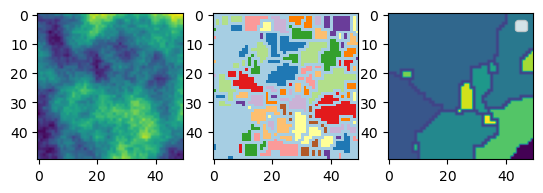

In [324]:
#trial of watersheds segmentations
terrain_map,tmp = Terrain_Gen("nlmpy",nRow=50, nCol=50, h=0.74)
l1,l2=WatershedsSeparation(terrain_map,levels=4)

#SIMULATION

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


_____________
__TERRAIN MAP__


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


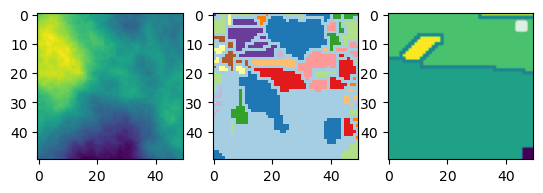

_____________
__NODES MAP__


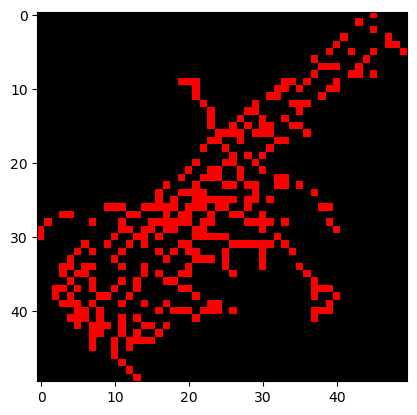

_____________
__SIMULATION COMPLETE__


In [327]:
#user settings
sim_num=6000

#clouds and terrain size
nRow=50
nCol=50
h=0.95

#plot options
PLOT_CLOUDS = False
GRADIENT_TRANSITION_SIZE = 3
CLOUDS_GENERATOR_TYPE = "nlmpy" #options - "nlmpy", "lorenz_attractor","white_noise"

#turn on different simulation options
DROP_ALL_ACCUMULATED_WATER=True
RUN_COORD_TEST = False
NODES_RUN_OFF_WITH_TERRAIN_PROFILE = False

#some objects to generate chaotic data
chaos_attr=None

#here we store the dynamics of the water versus time
time_series=[]
total_series=[]
target_nodes_list=[]
for edge in nx.edges(Graph):
    target_nod=edge[1]    
    target_nodes_list.append(target_nod)
#remove duplicates
s = []
for node in target_nodes_list:
   if node not in s:
      s.append(node)
      time_series.append([])
target_nodes_list=s

#compute coordinates correspondencies
ax=(max_x_coord-min_x_coord)/nRow
bx=min_x_coord
ay=(max_y_coord-min_y_coord)/nCol
by=min_y_coord

if(RUN_COORD_TEST==True):
    Coord_Tests(ax,bx,ay,by,min_x_coord,max_x_coord,min_y_coord,max_y_coord)

#this are the clouds
mat_show=None

front_buf,chaos_attr = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) #nlmpy.mpd(nRow=nRow, nCol=nCol, h=h)
back_buf,chaos_attr  = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) #nlmpy.mpd(nRow=nRow, nCol=nCol, h=h)
back_buf=CorrectWithTransitionMap(GRADIENT_TRANSITION_SIZE, map_1 = front_buf, map_2 = back_buf)

#plt.imshow(front_buf)
#plt.imshow(back_buf)

#predpare the terrain map
print("_____________")
print("__TERRAIN MAP__")

terrain_map=nlmpy.mpd(nRow=nRow, nCol=nCol, h=h)
l1,l2=WatershedsSeparation(terrain_map,levels=4)
#check the sized of each cluster
terrain_map_watersheds=l1
terrain_wsh_labels = np.unique(terrain_map_watersheds) #unique(terrain_map_watersheds)
terrain_wsh_size=[]
for i in range(0,len(terrain_wsh_labels)):
    value=np.count_nonzero(terrain_map_watersheds == terrain_wsh_labels[i])#terrain_map_watersheds.count(terrain_wsh_labels[i])
    terrain_wsh_size.append(value)
    
#print(terrain_wsh_size)
#print("------------------")
#print(terrain_wsh_labels)
#-----------------------------

cnt=0
sim_step=0

for i in range(0,sim_num):
        
    if(cnt > nRow + GRADIENT_TRANSITION_SIZE):
        sz_front_buf=np.shape(front_buf)
        front_buf= back_buf[0:sz_front_buf[0]][:]
        back_buf,chaos_attr = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) #nlmpy.mpd(nRow=50, nCol=50, h=0.75)
        back_buf=CorrectWithTransitionMap(GRADIENT_TRANSITION_SIZE, map_1 = front_buf, map_2 = back_buf)
        cnt=0

    mat_show=StickImages(step=cnt, map_1 = front_buf, map_2 = back_buf)
    #mat_show[:][0:cnt]=back_buf[:][0:cnt]
    cnt=cnt+1
        
    #simulate the input into the graph node
    #find the coordinate that corresponds to the coordinates on the *.inp graph
    for j in range(0,graph_nodes_n):
                
        pos_x=points[j][0]
        pos_y=points[j][1]      

        map_x=int((pos_x-bx)/ax)
        map_y=int((pos_y-by)/ay)

        if(map_x>=nRow):
            map_x=nRow-1
        if(map_y>=nCol):
            map_y=nCol-1       

        #upate values 
        value=mat_show[map_x,map_y]
        #nx.set_node_attributes(Graph, value, name="value")
        #fill in the nodes with water
        if(NODES_RUN_OFF_WITH_TERRAIN_PROFILE==False):
            #if the nodes are 
            Graph.nodes[Node_Names[j]]["value"]=Graph.nodes[Node_Names[j]]["value"] + value
        else:
            #chekc the label of the terrain first
            label = terrain_map[map_x][map_y]
            total_water_runoff=0
            for a in range(0,nRow):
                for b in range(0,nCol):
                    if(terrain_map_watersheds[a][b]==label):
                        total_water_runoff = total_water_runoff + mat_show[a,b]
            Graph.nodes[Node_Names[j]]["value"]=Graph.nodes[Node_Names[j]]["value"] + total_water_runoff
            #this is simplified version with averaging
            #indx = terrain_wsh_labels.index(label)
            #watershed_size = terrain_wsh_size[indx]            
            
        #gh=nx.get_node_attributes(Graph, name="value")
        #print("Map value")
        #print(value)
        #print("installed value")
        #print(gh)
        
    #make inference and run simulations
    
    total=0 #total water change    
    
    for edge in nx.edges(Graph):
        
        #this is water propagation modelling
        weight=Graph.get_edge_data(*edge)["weight"]
        out_n    = edge[0]     
        target_n = edge[1]
        out_n_val=Graph.nodes[out_n]["value"]
        target_n_val=Graph.nodes[target_n]["value"]  

        value_out_n    = out_n_val
        value_target_n = target_n_val
        
        #we check if the depth level has to be taken into account (this imposes delay)
        if(Graph.nodes[out_n]["depth"]!=0):
            if(value_out_n>=Graph.nodes[out_n]["depth"]):
                value_out_n=np.max(value_out_n-Graph.nodes[out_n]["depth"],0)
            else:
                value_out_n=0 
                
        #water propagation functions
        tmp  = value_out_n*weight+value_target_n # Do something useful with the edges      
        tmp1 = tmp
        
        #check if water level is too high in the target node and if it is saturated
        if(Graph.nodes[target_n]["saturation_falg"]==True):
            if (tmp1>=Graph.nodes[target_n]["sturation_level"]):
                tmp1=Graph.nodes[target_n]["sturation_level"]
                    
        #fill time series
        #indx=target_nodes_list.index(target_n)
        #total water change     
        #time_series[indx].append(tmp1)
        total=total+tmp

    #update the time series
    for node in target_nodes_list:
        tmp1=Graph.nodes[node]["value"]
        indx=target_nodes_list.index(node)
        time_series[indx].append(tmp1)
        
    #update the water level in all nodes
    if(DROP_ALL_ACCUMULATED_WATER!=False):
        for j in range(0,graph_nodes_n):
            cur_value=Graph.nodes[Node_Names[j]]["value"]
            if(Graph.nodes[out_n]["depth"]==0):        
                Graph.nodes[Node_Names[j]]["value"]=0
            else:
                if(cur_value<Graph.nodes[Node_Names[j]]["depth"]):
                    Graph.nodes[Node_Names[j]]["value"]=0
                else:
                    Graph.nodes[Node_Names[j]]["value"]=Graph.nodes[Node_Names[j]]["value"]
                    
    # update values in all target nodes with respect to water losses (if those imposed)
    for j in range(0,graph_nodes_n):        
        #add water losses here (becasue of precipitation, for example)
        if (Graph.nodes[Node_Names[j]]["water_loss_flag"]==True):
            water_loss_rate=Graph.nodes[Node_Names[j]]["water_loss_rate"]
            value=Graph.nodes[Node_Names[j]]["value"]
            value=water_loss_rate*value
            Graph.nodes[Node_Names[j]]["value"]=value                                            
                
    #print("DATA for sim.num. "+str(sim_step)+": "+str(total))
    total_series.append(total)
    sim_step=sim_step + 1         
        
    #in case we sould like to check the clouds distributon and how it evolves
    if PLOT_CLOUDS==True:

        if(sim_step==0):
            print("_____________")
            print("__CLOUDS MAP__")

        
        print("Simulation step: "+str(sim_step))
        plt.matshow(mat_show)
        plt.colorbar()
        plt.show()
    
print("_____________")
print("__NODES MAP__")

blank_image = np.zeros((nRow,nCol,3), np.uint8)
for j in range(0,graph_nodes_n):
    pos_x=points[j][0]
    pos_y=points[j][1]
    map_x=int((pos_x-bx)/ax)
    map_y=int((pos_y-by)/ay)
    if(map_x>=nRow):
        map_x=nRow-1
    if(map_y>=nCol):
        map_y=nCol-1
    blank_image[map_x,map_y,0]=252

plt.imshow(blank_image)
plt.show()

print("_____________")
print("__SIMULATION COMPLETE__")

number of target nodes - 366
Name of node:102a , tie series length: 6000
Name of node:102b , tie series length: 6000
Name of node:102c , tie series length: 6000
Name of node:102e , tie series length: 6000
Name of node:102f , tie series length: 6000
Name of node:102g , tie series length: 6000
Name of node:SK_102_Steuerschacht , tie series length: 6000
Name of node:102d , tie series length: 6000
Name of node:103b , tie series length: 6000
Name of node:103c , tie series length: 6000
Name of node:103d_SBW , tie series length: 6000
Name of node:104b , tie series length: 6000
Name of node:104c , tie series length: 6000
Name of node:104d , tie series length: 6000
Name of node:105 , tie series length: 6000
Name of node:106 , tie series length: 6000
Name of node:121 , tie series length: 6000
Name of node:1101 , tie series length: 6000
Name of node:1102 , tie series length: 6000
Name of node:1103 , tie series length: 6000
Name of node:1104 , tie series length: 6000
Name of node:1105 , tie series

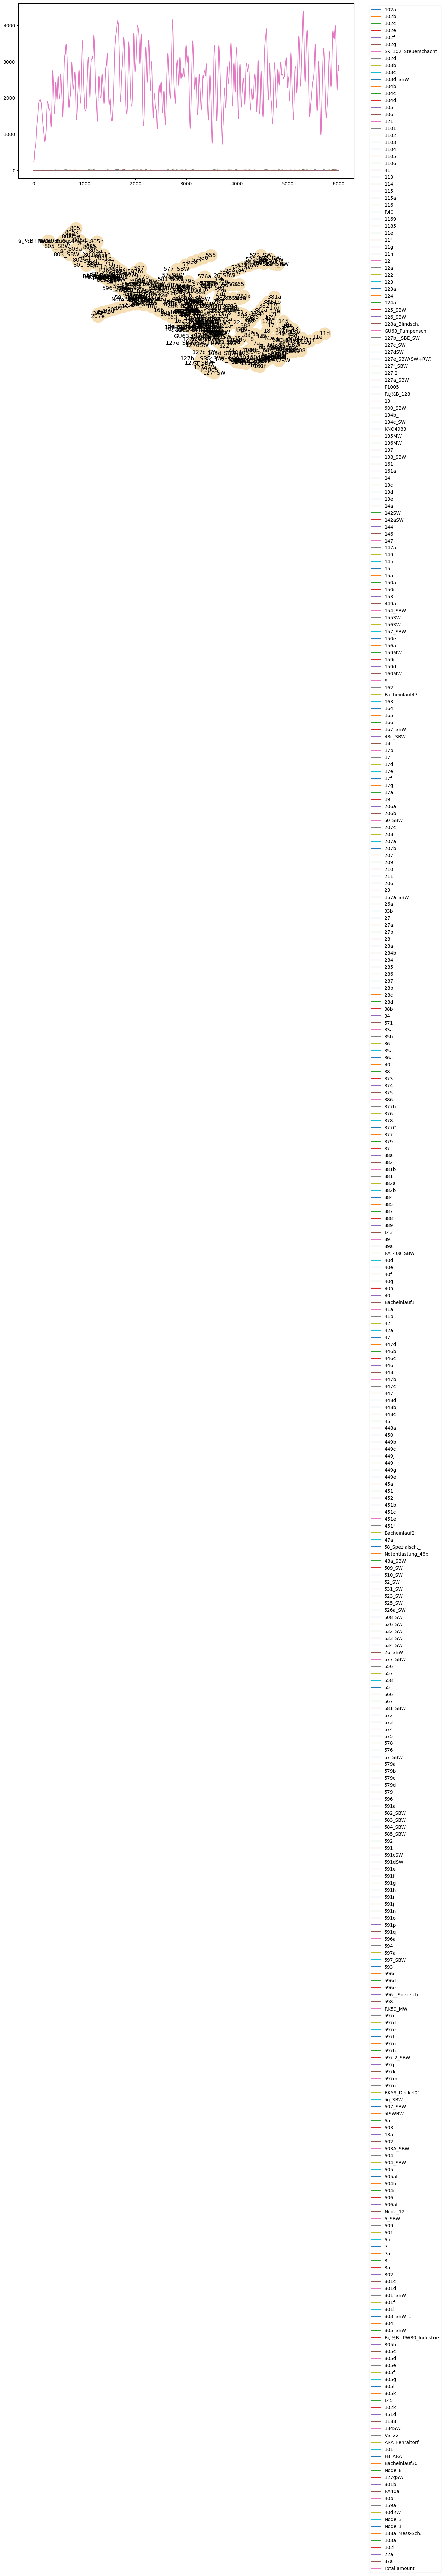

In [328]:
fig, (ax1,ax2) = plt.subplots(2); #plt.clf()
fig.set_figheight(15)
fig.set_figwidth(13)
print("number of target nodes - "+str(len(time_series)))
for i in range(0,len(time_series)):
    print("Name of node:" + target_nodes_list[i]+" , tie series length: "+str(len(time_series[i])))
    ax1.plot(time_series[i],label=target_nodes_list[i])
ax1.plot(total_series,label="Total amount")
ax1.legend(bbox_to_anchor=(1.04, 1), loc="upper left")#"upper right")
#plot graph
nx.draw(Graph, pos=pos2, node_color='wheat', node_size=700,with_labels=True,ax=ax2)
pylab.show()
plt.show()

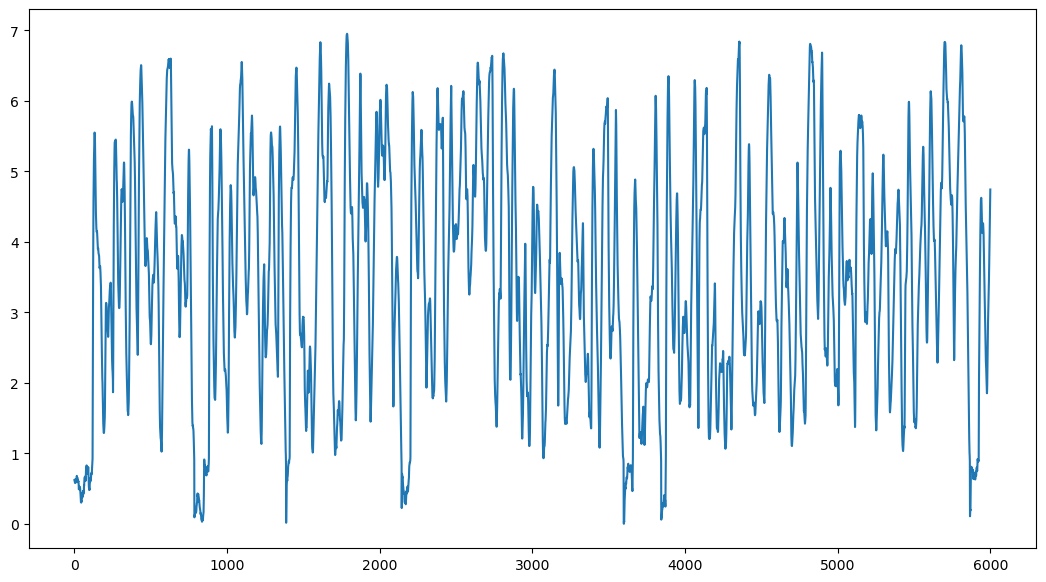

In [333]:
fig, ax1 = plt.subplots(1)
fig.set_figheight(7)
fig.set_figwidth(13)
ax1.plot(time_series[2],label=target_nodes_list[i])

In [293]:
#show attractor trajectory
if(chaos_attr == None):
    print("Attractor object is empty")
else:
    xyzs=np.asarray(chaos_attr.xyz_hist)
    # Plot
    ax = plt.figure().add_subplot(projection='3d')

    ax.plot(*xyzs.T, lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Lorenz Attractor")
    plt.show()

Attractor object is empty


In [429]:
#functions that cut the time series 
def prepare_training_sets(dataset, in_pattern_size=1000, out_pattern_size=1000):
    
    in_set=[]
    out_set=[]
    for i in range(0,len(dataset)):
        
        in_tmp=[]
        out_tmp=[]

        jkl=dataset[i]
        cur_pos=0
        for k in range(0,len(jkl)):
            if(cur_pos+in_pattern_size>len(jkl)):
                break
            if(cur_pos+in_pattern_size+out_pattern_size>len(jkl)):
                break
            tmp1=jkl[cur_pos:(cur_pos+in_pattern_size)]
            tmp2=jkl[(cur_pos+in_pattern_size):(cur_pos+in_pattern_size+out_pattern_size)]
            in_tmp.append(tmp1)
            out_tmp.append(tmp2)

            cur_pos=cur_pos+in_pattern_size
                    
        in_set.append(np.asarray(in_tmp))
        out_set.append(np.asarray(out_tmp))        
    return in_set, out_set

Size of training sets (number of time series): inputs - 8 , outputs - 8
Size of each training set: inputs - 58 , outputs -   58
Length of the patterns: inputs - 100 , outputs - 200
(100,)


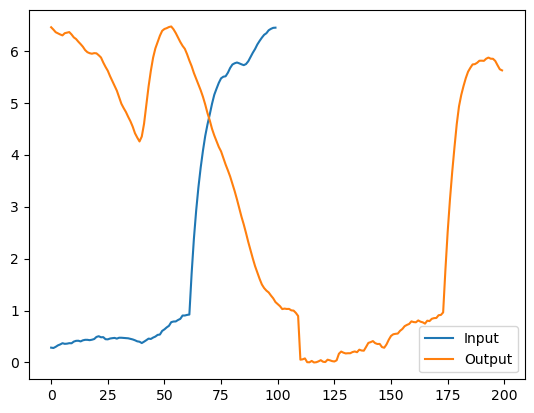

In [451]:
#PREPARE THE DATA SETS FOR TRAINING
IN_PATTERN_SIZE=100
OUT_PATTERN_SIZE=200

SHOW_ONE_EXAMPLE=True
NODE_NUMBER=1
EXAMPLE_NUM=2

in_pattern,out_pattern=prepare_training_sets(time_series,in_pattern_size=IN_PATTERN_SIZE, out_pattern_size=OUT_PATTERN_SIZE)
print("Size of training sets (number of time series): inputs - "+str(len(in_pattern))+" , outputs - "+ str(len(out_pattern)))
print("Size of each training set: inputs - "+str(len(in_pattern[0]))+" , outputs - "+"  " +str(len(out_pattern[0])))
print("Length of the patterns: inputs - " +str(len(in_pattern[0][0]))+" , outputs - " + str(len(out_pattern[0][0])))
print(np.shape(in_pattern[NODE_NUMBER][EXAMPLE_NUM]))
plt.plot(in_pattern[EXAMPLE_NUM][EXAMPLE_NUM],label='Input')
plt.plot(out_pattern[EXAMPLE_NUM][EXAMPLE_NUM],label='Output')
plt.legend()
plt.show()

In [363]:
#random fields with Riemanian geometric approach on acyclic graphs

In [365]:
#library to operate on garph signals - PyGSP,
#https://pygsp.readthedocs.io/en/stable/
#https://github.com/mdeff/pygsp_tutorial_graphsip

In [423]:
class Rand_Field_Bayes:
    
    def __init__(self):
        self.Graph=nx.DiGraph(directed=True,strict=True)    
        self.node_names=[]

    def InitDefault(self,nodes_num=1000,p=0.5):
        #p indicates connectivity in %
        self.Graph=nx.DiGraph(directed=True,strict=True)    
        self.node_names=[]
        for i in range(0,nodes_num):
            node_name=''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(7))
            self.node_names.append(node_name)
            self.Graph.add_node(node_name, 
                                value=float(0.0), #actual water level                    
                                weight=random.uniform(0.01, .99)
                               )
            
        kl=int(p*nodes_num)
        for i in range(0,kl):
            out_n_num=random.randrange(nodes_num) 
            target_n=random.randrange(nodes_num) 
            self.Graph.add_edge(self.node_names[out_n_num], self.node_names[target_n])
        
        return self.Graph
                            
    def Train(self, x, y):
        
        shp_x=np.shape(x)
        shp_y=np.shape(y)
        print("Cond.random fields training: ")
        print("received inputs size - " + str(shp_x))
        print("receied outputs size - " + str(shp_y))
        #converting to graoh signals
        #https://nbviewer.org/github/mdeff/pygsp_tutorial_graphsip/blob/outputs/notebooks/02_spectral.ipynb
        grah_in=[]
        graph_out=[]
        for i in range(0,np.max(len(x),len(y))):
            if(i<len(x)):
                grah_in.append(np.asarray(x[i]))
            if(i<len(y)):
                graph_out.append(np.asarray(y[i]))
        
        start_time=time.time()
        print("Start training.....")        
        #traning procedure
        while(False):
            break
        print("Training complete in "+str(time.time() - start_time)+" s")
    
    def Inference(self,Input):
    
        #nodes_p=dict([((u),d['points']) for u,d in self.Graph.nodes(data=True)])
        #first, fill the values
        cnt=0

        for u,outer_d in self.Graph.nodes(data=True):           
            self.Graph.nodes[u]['value']=float(Input[cnt])
            cnt=cnt+1
           
        for edge in nx.edges(self.Graph):      
            
            #this is water propagation modelling
            #weight_out=self.Graph.get_edge_data(*edge)["weight"]
            
            out_n    = edge[0]     
            target_n = edge[1]
            out_n_val=self.Graph.nodes[out_n]["value"]
            target_n_val=self.Graph.nodes[target_n]["value"]  

            out_n_w=self.Graph.nodes[out_n]["weight"]
            target_n_w=self.Graph.nodes[target_n]["weight"]      
    
            target_n_val    = target_n_val + out_n_val*target_n_w
            self.Graph.nodes[target_n]["value"] = target_n_val  

In [425]:
#utility for big graphs vizuaization
#https://nightingaledvs.com/how-to-visualize-a-graph-with-a-million-nodes/
#vizualize raph with networkX
start_time = time.time()
asa=Rand_Field_Bayes()
asa.InitDefault(nodes_num=10000)
print("Iniatilzation: time - " + str(time.time()-start_time))
print("Number of nodes: " + str(asa.Graph.number_of_nodes()))
print("Number of edges: "+str(asa.Graph.number_of_edges()))
#check for test inference with this amount of nodes
x=np.random.randint(10, size=(asa.Graph.number_of_nodes()))
start_time = time.time()
asa.Inference(x)
print("Inference time: "+str(time.time()-start_time))

Iniatilzation: time - 0.05578136444091797
Number of nodes: 10000
Number of edges: 5000
Inference time: 0.011117935180664062


In [427]:
asa.Train(np.asarray(in_pattern[0]),np.asarray(out_pattern[0]))

Cond.random fields training: 
received inputs size - (5, 1000)
receied outputs size - (5, 1000)


AxisError: axis 5 is out of bounds for array of dimension 0

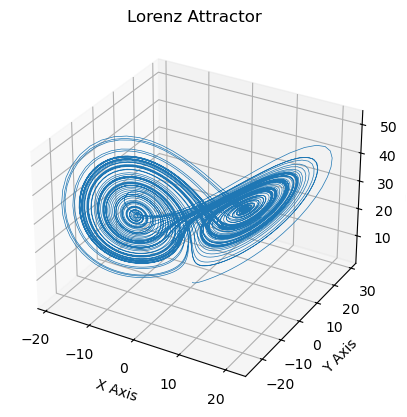

In [315]:
import matplotlib.pyplot as plt
import numpy as np

def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])


dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
plt.show()

SyntaxError: invalid syntax (3026082339.py, line 1)

In [959]:
bitte 

NameError: name 'bitte' is not defined